# Мастерская 2 — Маркетинг интернет-магазина

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей 
которые готовы совершить покупку в ближайшее врем

Нам предоставлены данные по истории покупателей. У нас есть история того как тот или иной покупатель реагировал на коммуникацию, которая проводилась. Под коммуникацией мы имеем ввиду, например, промо-предложение, направленное в смс / push сообщении. По каждому товару проставлена категория, которая помогает определить насколько покупатель “латентен” (предпочтителен) к этой группе товаров.

**Цель** -  создать модель прогнозирования покупки каждым покупателем в ближайшие 90 дней. Это нужно для улучшения работы и повышения эффективности марктетинговых компаний.

### Описание данных

* ```apparel-purchases```

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. **Необходимо обработать такие случаи**.

```client_id``` - идентификатор клиента 

```quantity``` - количество единиц товара

```price``` - цена товара

```category_ids``` - идентификаторы категорий

```date``` - дата покупки

```message_id``` - идентификатор сообщения из рассылки

* ```apparel-messages```

Рассылки, которые были отправлены клиентам из таблицы покупок.

```bulk_campaign_id``` -  идентификатор рассылки

```client_id``` - идентификатор клиента

```message_id```  - идентификатор сообщения

```event``` - действие с сообщением (отправлено, открыто, покупка…)

```channel``` - канал рассылки

```date``` - дата действия

```created_at``` - дата-время полностью

* target

```client_id``` - идентификатор клиента

```target``` - клиент совершил покупку в целевом периоде

* full_campaign_daily_event

Агрегация общей базы рассылок по дням и типам событий

```date``` - дата

```bulk_campaign_id``` - идентификатор рассылки

```count_event*``` - общее количество каждого события event

```nunique_event*``` - количество уникальных client_id в каждом событии

*в именах колонок найдете все типы событий event

* full_campaign_daily_event_channel

Агрегация по дням с учетом событий и каналов рассылки

```date``` - дата

```bulk_campaign_id``` - идентификатор рассылки

```count_event*_channel``` - общее количество каждого события по каналам

```nunique_event*_channel``` - количество уникальных client_id по событиям и каналам

*в именах колонок есть все типы событий event и каналов рассылки channel

In [2]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import shap
from scipy.stats import spearmanr, shapiro, stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import phik
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

# Загрузка данных

In [3]:
df_messages = pd.read_csv(r"C:\Users\Александр\Desktop\Worksop2\filtered_data\apparel-messages.csv")
df_purchases = pd.read_csv(r"C:\Users\Александр\Desktop\Worksop2\filtered_data\apparel-purchases.csv")
df_target = pd.read_csv(r"C:\Users\Александр\Desktop\Worksop2\filtered_data\apparel-target_binary.csv")
df_event = pd.read_csv(r"C:\Users\Александр\Desktop\Worksop2\filtered_data\full_campaign_daily_event.csv")
df_event_channel = pd.read_csv(r"C:\Users\Александр\Desktop\Worksop2\filtered_data\full_campaign_daily_event_channel.csv")

In [4]:
df_target.shape

(49849, 2)

In [5]:
df_purchases.shape

(202208, 6)

In [70]:
df_messages.shape

(12656659, 7)

# Предобработка данных

In [6]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


**В данных `df_messages` есть несоответствие типов данных**

In [7]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [8]:
df_messages['date'] = pd.to_datetime(df_messages['date'], format='%Y-%m-%d')

**Изменим тип данных пока только в столбце `date`, далее в ходе выполнения посмотрим какие данные нам пригодятся**

In [9]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 680.4+ MB


In [10]:
df_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

**Не смотря на обилие данных, пропусков в данных нет**

In [11]:
df_messages.duplicated().sum()

48610

**Дубликатов 48 тысяч, но их можно удалить так как общий объем данных в `df_messages` больше миллиона**

In [12]:
df_messages = df_messages.drop_duplicates()

In [13]:
df_messages.duplicated().sum()

0

**Дубликаты устранены**

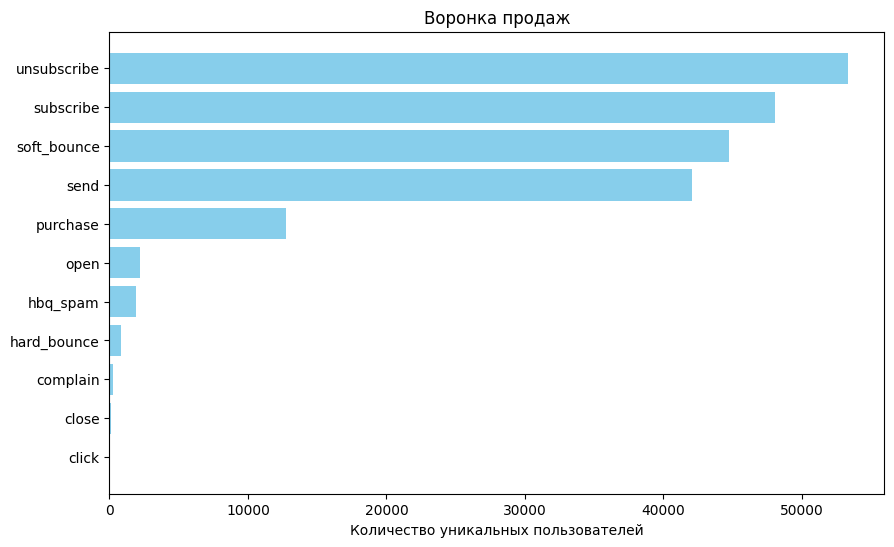

In [14]:
funnel = df_messages.groupby('event')['client_id'].nunique().reset_index()
funnel = funnel.rename(columns={'client_id': 'unique_clients'})

# Визуализация воронки
plt.figure(figsize=(10, 6))
plt.barh(funnel['event'], funnel['unique_clients'].sort_values(), color='skyblue')
plt.xlabel('Количество уникальных пользователей')
plt.title('Воронка продаж')
plt.show()

**Исходя из воронки продаж видно, что не всех пользователей устраивает рассылка. Многие пользователи отписываются, пишут жалобы, сообщение уходит в спам, ну или вообще по техническим причинам не доходит**

In [15]:
df_messages = df_messages.loc[df_messages['event']!='unsubscribe']
df_messages = df_messages.loc[df_messages['event']!='soft_bounce']
df_messages = df_messages.loc[df_messages['event']!='hbq_spam']
df_messages = df_messages.loc[df_messages['event']!='hard_bounce']
df_messages = df_messages.loc[df_messages['event']!='complain']
df_messages = df_messages.loc[df_messages['event']!='close']

**Удалим строки с неустраивающими нас действиями, эти пользватели явно не купят товар в ближайшие 90 дней**

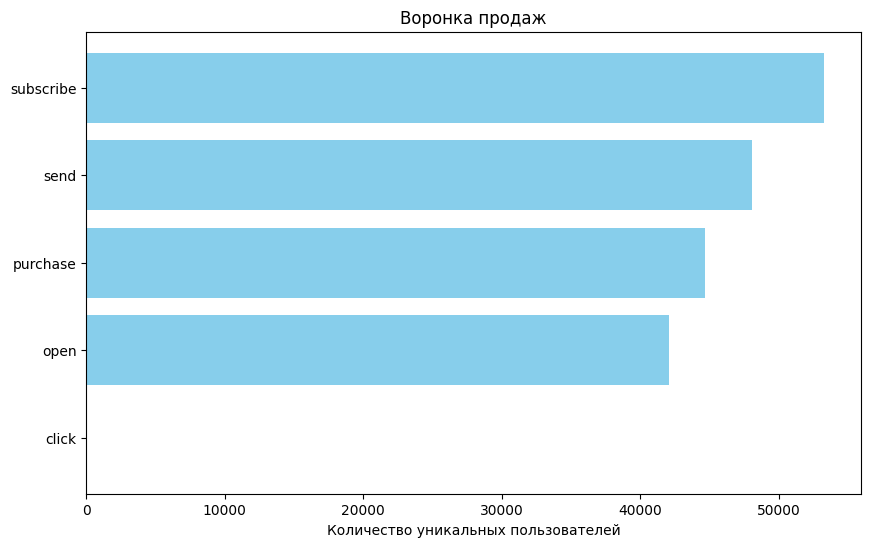

In [16]:
funnel = df_messages.groupby('event')['client_id'].nunique().reset_index()
funnel = funnel.rename(columns={'client_id': 'unique_clients'})

# Визуализация воронки
plt.figure(figsize=(10, 6))
plt.barh(funnel['event'], funnel['unique_clients'].sort_values(), color='skyblue')
plt.xlabel('Количество уникальных пользователей')
plt.title('Воронка продаж')
plt.show()

**Данные отфильтрованы, но в воронке продаж есть несоответствие, так как действия располлжены в неверном порядке, оставим пока так как есть из-за того, что это основной датафрейм, в дальнейшем по необходимости преобразуем**

In [18]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


**В `df_purchases` также наблюдается несоответствие данных**

In [19]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [20]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'], format='%Y-%m-%d')

**Заменим тип данных в столбце `date`**

In [21]:
df_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

**Пропуски в `df_purchases` отсутствуют, дубликаты в данном фрейме проверять я считаю бессмыслено. Все потому что у нас нет данных о времени заказа, а люди могут заказывать один и тот же товар несколько раз.**

In [22]:
df_purchases['client_message_id'] = df_purchases['message_id'].str.split('-').str[0]
df_purchases['bulk_campaign_id_message_id'] = df_purchases['message_id'].str.split('-').str[1]
df_purchases['message_id_code'] = df_purchases['message_id'].str.split('-').str[2]

**Так как `message_id` состоит из трех частей `client_message_id`, `bulk_campaign_id_message_id`, `message_id_code` разделим их, чтобы проверить на соответствие**

In [23]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,client_message_id,bulk_campaign_id_message_id,message_id_code
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843


In [24]:
df_purchases_1 = df_purchases.copy()

In [25]:
df_purchases_1['client_message_id'] = df_purchases_1['client_message_id'].astype('int64')

In [26]:
df_purchases_1 = df_purchases_1.loc[(df_purchases_1['client_id']==df_purchases_1['client_message_id'])]

**Оставим в датафрейме только тех клиентов у которых совпадает `client_id` и первая составляющая `message_id`**

In [27]:
df_purchases_1.shape

(146525, 9)

**Из датафрейма было удалено порядка 50000 строк**

In [28]:
df_purchases_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146525 entries, 0 to 202203
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   client_id                    146525 non-null  int64         
 1   quantity                     146525 non-null  int64         
 2   price                        146525 non-null  float64       
 3   category_ids                 146525 non-null  object        
 4   date                         146525 non-null  datetime64[ns]
 5   message_id                   146525 non-null  object        
 6   client_message_id            146525 non-null  int64         
 7   bulk_campaign_id_message_id  146525 non-null  object        
 8   message_id_code              146525 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 11.2+ MB


In [29]:
df_purchases_1 = df_purchases_1.drop(['client_message_id', 'bulk_campaign_id_message_id', 'message_id_code'], axis=1)

In [30]:
df_purchases_1

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202199,1515915626010261344,1,1499.00,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202200,1515915626010261344,1,1499.00,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.00,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1499.00,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


**Вернем датафрейм в исходный вид**

In [31]:
df_grouped = df_purchases_1.groupby(['client_id', 'category_ids', 'date', 'message_id'], as_index=False).agg({'quantity': 'sum', 'price': 'sum'})

**Так как в столбце `quantity` все по одному товару, сгруппируем датафрейм по столбцам `client_id`, `category_ids`, `date`, `message_id` чтобы сложить `quantity` и `price`**

In [32]:
df_grouped

,client_id,category_ids,date,message_id,quantity,price
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,2,398.00
1,1515915625468060902,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.00
2,1515915625468060902,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1,999.00
3,1515915625468060902,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.00
4,1515915625468060902,"['4', '28', '290', '422']",2022-05-27,1515915625468060902-4617-6290657dac196,1,299.00
...,...,...,...,...,...,...
73109,1515915626010079153,"['2', '18', '258', '1195']",2024-02-13,1515915626010079153-14632-65c9f5c98af32,2,5132.00
73110,1515915626010079153,"['2', '18', '61', '661']",2024-02-13,1515915626010079153-14632-65c9f5c98af32,2,2828.00
73111,1515915626010152263,"['2', '18', '267', '443']",2024-02-14,1515915626010152263-14649-65cca1b63edf7,4,1676.00
73112,1515915626010221592,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,2,2998.00


**Датафрейм еще раз сократился в 2 раза, но данные мы не потеряли**

In [33]:
def process_categories(categories):
    
    categories_list = [cat.strip() for cat in categories.strip('[]').split(',')]
    
    
    unique_categories = sorted(set(categories_list), key=categories_list.index)  
    
    
    return ', '.join(unique_categories)


df_grouped['category_ids'] = df_grouped['category_ids'].apply(process_categories)

In [34]:
df_grouped

,client_id,category_ids,date,message_id,quantity,price
0,1515915625468060902,"'4', '27', '176', '458'",2022-05-27,1515915625468060902-4617-6290657dac196,2,398.00
1,1515915625468060902,"'4', '27', '1828', '1599'",2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.00
2,1515915625468060902,"'4', '28', '244', '432'",2022-05-27,1515915625468060902-4617-6290657dac196,1,999.00
3,1515915625468060902,"'4', '28', '260', '420'",2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.00
4,1515915625468060902,"'4', '28', '290', '422'",2022-05-27,1515915625468060902-4617-6290657dac196,1,299.00
...,...,...,...,...,...,...
73109,1515915626010079153,"'2', '18', '258', '1195'",2024-02-13,1515915626010079153-14632-65c9f5c98af32,2,5132.00
73110,1515915626010079153,"'2', '18', '61', '661'",2024-02-13,1515915626010079153-14632-65c9f5c98af32,2,2828.00
73111,1515915626010152263,"'2', '18', '267', '443'",2024-02-14,1515915626010152263-14649-65cca1b63edf7,4,1676.00
73112,1515915626010221592,"'4', '28', '260', '1194'",2024-02-16,1515915626010221592-14664-65cf1622434a9,2,2998.00


In [37]:
def process_categories(categories):
    # Превращаем строку категорий в список, убирая возможные лишние пробелы
    categories_list = [cat.strip() for cat in categories.split(',')]
    
    # Возвращаем последнюю категорию из списка
    return categories_list[-1] if categories_list else None

# Применяем функцию ко всему столбцу category_ids
df_grouped['category_ids'] = df_grouped['category_ids'].apply(process_categories)

In [38]:
df_grouped.head()

,client_id,category_ids,date,message_id,quantity,price
0,1515915625468060902,'458',2022-05-27,1515915625468060902-4617-6290657dac196,2,398.00
1,1515915625468060902,'1599',2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.00
2,1515915625468060902,'432',2022-05-27,1515915625468060902-4617-6290657dac196,1,999.00
3,1515915625468060902,'420',2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.00
4,1515915625468060902,'422',2022-05-27,1515915625468060902-4617-6290657dac196,1,299.00


**Тут я не особо разобрался как можно обработать категории, и решил оставить самую глубокую категорию. Понимаю, что в пересечении могла получится категория которая встречается чаще. Но хоть таким образом уменьшим количество уникальных данных**

In [39]:
df_grouped['category_ids'].nunique()

842

In [40]:
df_grouped.isna().sum()

client_id       0
category_ids    0
date            0
message_id      0
quantity        0
price           0
dtype: int64

In [41]:
df_grouped['category_ids'] = df_grouped['category_ids'].str.replace("'", "")

In [42]:
df_grouped = df_grouped.loc[df_grouped['category_ids']!='None']
df_grouped = df_grouped.loc[df_grouped['category_ids']!='']

In [43]:
df_grouped['category_ids'] = df_grouped['category_ids'].astype('int64')

**Удалим строки с пропусками в категориях и поменяем тип данных**

In [44]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70972 entries, 0 to 73113
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     70972 non-null  int64         
 1   category_ids  70972 non-null  int64         
 2   date          70972 non-null  datetime64[ns]
 3   message_id    70972 non-null  object        
 4   quantity      70972 non-null  int64         
 5   price         70972 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [45]:
df_grouped['day_of_week'] = df_grouped['date'].dt.dayofweek

In [46]:
df_grouped['year'] = df_grouped['date'].dt.year

In [47]:
df_grouped['avg_price'] = df_grouped['price'] / df_grouped['quantity']

**Создадим новые признаки `day_of_week`, `year`, `avg_price` в датафрейме с покупками** 

In [48]:
df_grouped.head()

,client_id,category_ids,date,message_id,quantity,price,day_of_week,year,avg_price
0,1515915625468060902,458,2022-05-27,1515915625468060902-4617-6290657dac196,2,398.00,4,2022,199.00
1,1515915625468060902,1599,2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.00,4,2022,1299.00
2,1515915625468060902,432,2022-05-27,1515915625468060902-4617-6290657dac196,1,999.00,4,2022,999.00
3,1515915625468060902,420,2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.00,4,2022,1999.00
4,1515915625468060902,422,2022-05-27,1515915625468060902-4617-6290657dac196,1,299.00,4,2022,299.00


# Исследовательский анализ данных

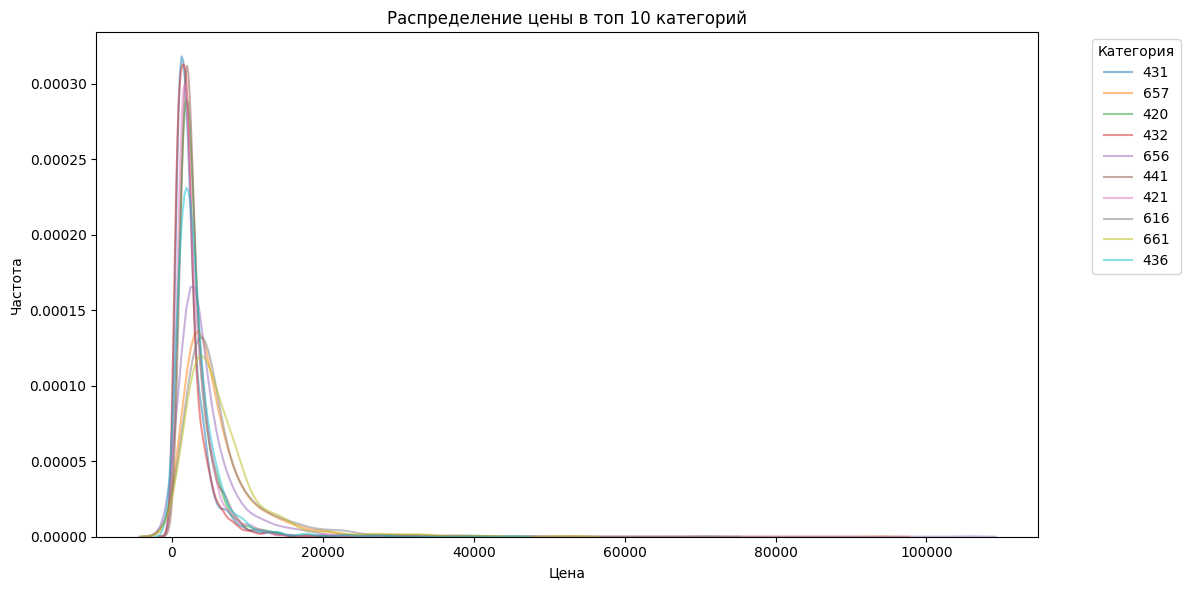

In [49]:
top_categories = df_grouped.groupby('category_ids')['price'].sum().nlargest(10).index


filtered_data = df_grouped[df_grouped['category_ids'].isin(top_categories)]


plt.figure(figsize=(12, 6))


for category in top_categories:
    sns.kdeplot(data=filtered_data[filtered_data['category_ids'] == category],
                 x='price', label=category, common_norm=False, alpha=0.5)


plt.title('Распределение цены в топ 10 категорий')
plt.xlabel('Цена')
plt.ylabel('Частота')


plt.legend(title='Категория', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 

plt.show()

**Распредление дохода в топ 10 категорий напоминает распредление Пуассона**

C:\Users\Александр\AppData\Local\Temp\ipykernel_26324\4014673937.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_clients, x='client_id', y='price', palette='viridis')


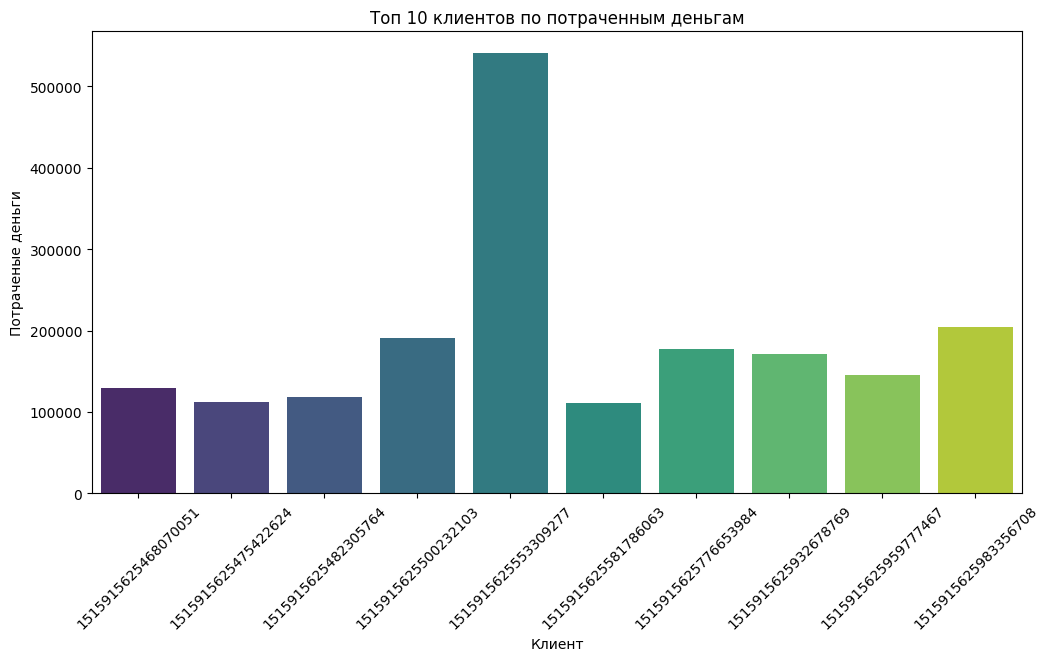

In [74]:
top_clients = df_grouped.groupby('client_id')['price'].sum().nlargest(10)


top_clients = top_clients.reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='client_id', y='price', palette='viridis')
plt.title('Топ 10 клиентов по потраченным деньгам')
plt.xlabel('Клиент')
plt.ylabel('Потраченые деньги')
plt.xticks(rotation=45) 
plt.show()

**В среднем топ 10 клиентов потратили более 100000 рублей но есть один, который потратил более 500000 рублей**

C:\Users\Александр\AppData\Local\Temp\ipykernel_26324\287064533.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_clients, x='client_id', y='quantity', palette='viridis')


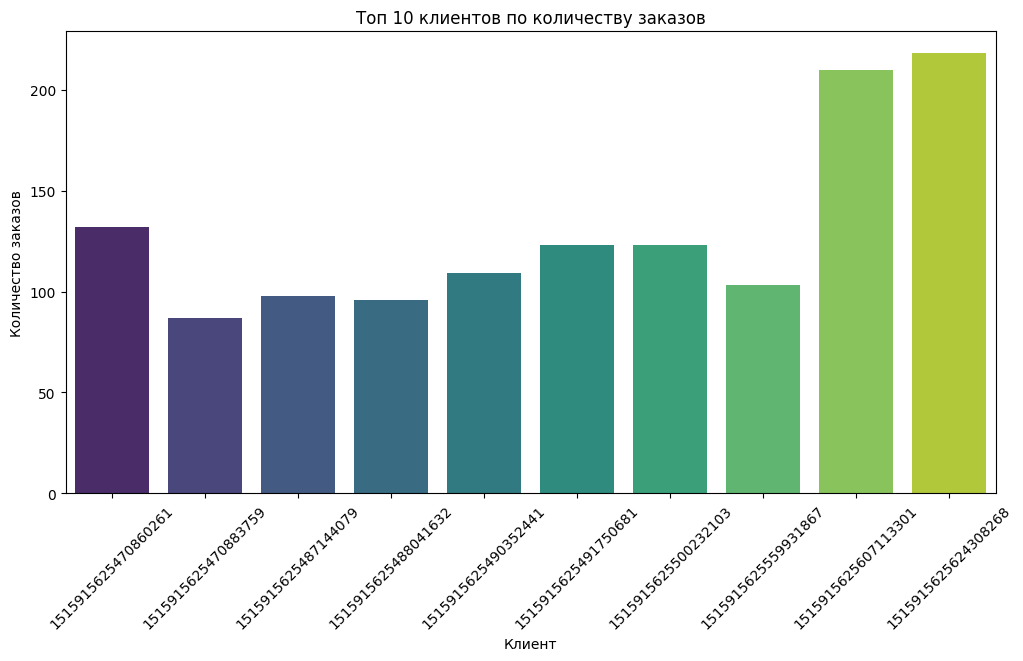

In [75]:
top_clients = df_grouped.groupby('client_id')['quantity'].sum().nlargest(10)

top_clients = top_clients.reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='client_id', y='quantity', palette='viridis')
plt.title('Топ 10 клиентов по количеству заказов')
plt.xlabel('Клиент')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45) 
plt.show()

**Топ 10 клиентов в среднем совершают около 100 заказов**

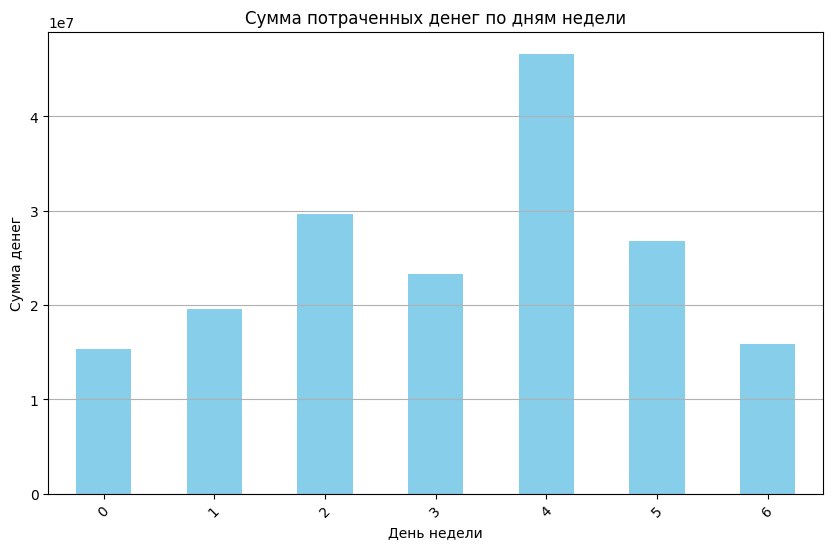

In [77]:
weekly_spending = df_grouped.groupby('day_of_week')['price'].sum()

plt.figure(figsize=(10, 6))
weekly_spending.plot(kind='bar', color='skyblue')
plt.title('Сумма потраченных денег по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма денег')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

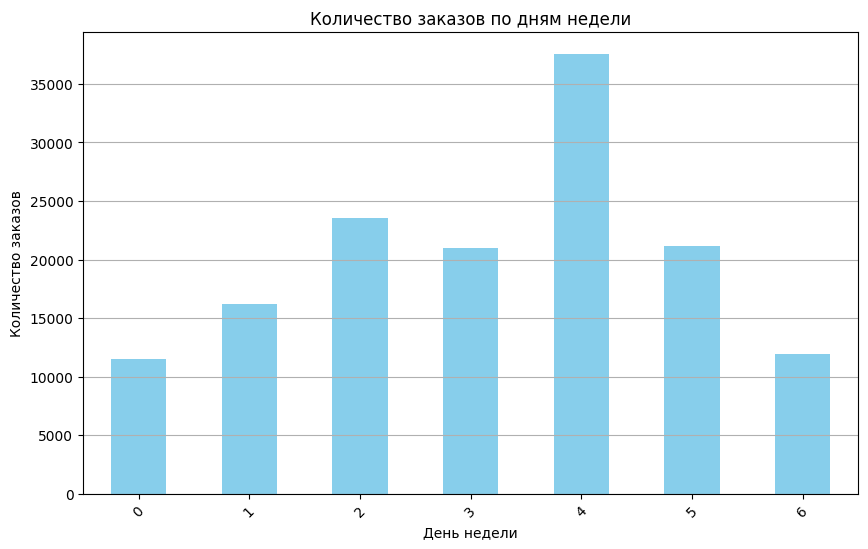

In [80]:
weekly_spending = df_grouped.groupby('category_ids')['quantity'].sum()

plt.figure(figsize=(10, 6))
weekly_spending.plot(kind='bar', color='skyblue')
plt.title('Количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Как ни странно но самый насыщенный день на заказы это пятница**

C:\Users\Александр\AppData\Local\Temp\ipykernel_26324\276563907.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_clients, x='category_ids', y='quantity', palette='viridis')


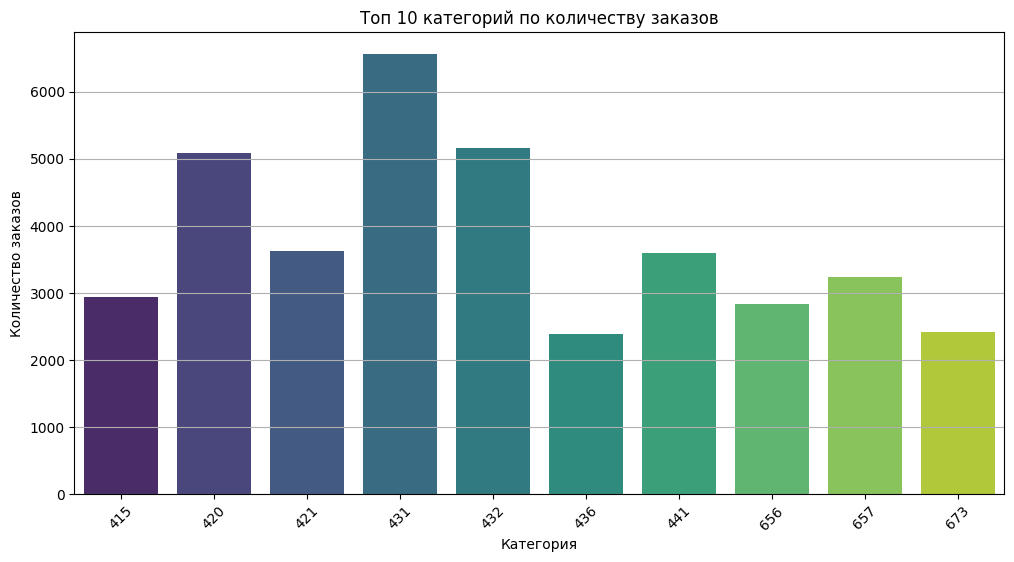

In [82]:
top_clients = df_grouped.groupby('category_ids')['quantity'].sum().nlargest(10)

top_clients = top_clients.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='category_ids', y='quantity', palette='viridis')
plt.title('Топ 10 категорий по количеству заказов')
plt.xlabel('Категория')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

C:\Users\Александр\AppData\Local\Temp\ipykernel_26324\348660402.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_clients, x='category_ids', y='price', palette='viridis')


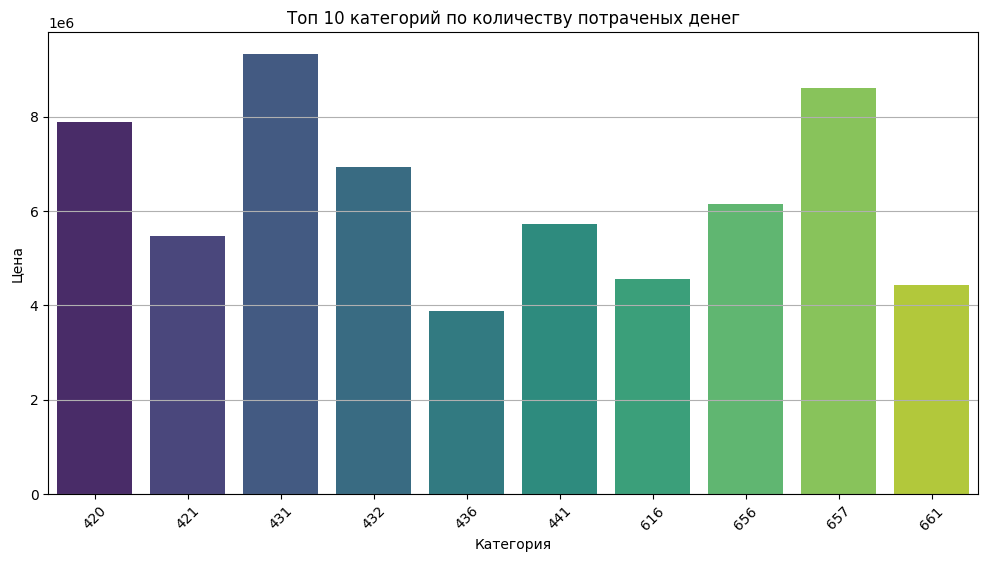

In [83]:
top_clients = df_grouped.groupby('category_ids')['price'].sum().nlargest(10)

top_clients = top_clients.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='category_ids', y='price', palette='viridis')
plt.title('Топ 10 категорий по количеству потраченых денег')
plt.xlabel('Категория')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**В топ 10 категориях в среднем около 3000 заказов и потрачено в среднем 5 млн. рублей**

In [51]:
df = df_grouped.merge(df_messages, on=['client_id', 'message_id'], how='inner')

**Объеденим датафрейм с покупками и сообщениями**

In [52]:
df.duplicated().sum()

4

In [53]:
df = df.drop_duplicates()

**Удалим 4 будликата, так как они навредят при обучении модели**

In [54]:
df['time_between_message_purchase'] = (df['date_x'] - df['date_y']).dt.days

In [55]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')
df['time_between_message_event'] = (df['date_y'] - df['date_y']).dt.days

**Я решил создать новые признаки такие как `time_between_message_purchase`- количество дней между отправкой сообщения и покупкой, `time_between_message_event`- количество дней между отправкой сообщения и действием**

In [56]:
cols = ['date_x', 'message_id', 'bulk_campaign_id', 'event', 'channel', 'date_y', 'created_at']
df = df.drop(cols, axis=1)

**Удалим столбцы которые не будут принимать участие в обучении модели**

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370972 entries, 0 to 370975
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   client_id                      370972 non-null  int64  
 1   category_ids                   370972 non-null  int64  
 2   quantity                       370972 non-null  int64  
 3   price                          370972 non-null  float64
 4   day_of_week                    370972 non-null  int32  
 5   year                           370972 non-null  int32  
 6   avg_price                      370972 non-null  float64
 7   time_between_message_purchase  370972 non-null  int64  
 8   time_between_message_event     370972 non-null  int64  
dtypes: float64(2), int32(2), int64(5)
memory usage: 25.5 MB


In [58]:
df = df.merge(df_target, on='client_id', how='left')

**Дабавим Таргет в данные**

<Axes: >

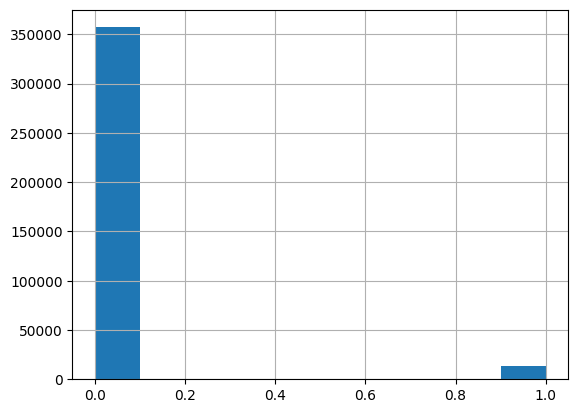

In [81]:
df['target'].hist()

**В данных наблюдается достаточно большой дисбаланс классов, если он навредит обучению модели будем с этим что то делать**

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370972 entries, 0 to 370971
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   client_id                      370972 non-null  int64  
 1   category_ids                   370972 non-null  int64  
 2   quantity                       370972 non-null  int64  
 3   price                          370972 non-null  float64
 4   day_of_week                    370972 non-null  int32  
 5   year                           370972 non-null  int32  
 6   avg_price                      370972 non-null  float64
 7   time_between_message_purchase  370972 non-null  int64  
 8   time_between_message_event     370972 non-null  int64  
 9   target                         370972 non-null  int64  
dtypes: float64(2), int32(2), int64(6)
memory usage: 25.5 MB


In [60]:
df.isna().sum()

client_id                        0
category_ids                     0
quantity                         0
price                            0
day_of_week                      0
year                             0
avg_price                        0
time_between_message_purchase    0
time_between_message_event       0
target                           0
dtype: int64

**Данные готовы к обучению**

# Корреляционный анализ

interval columns not set, guessing: ['category_ids', 'quantity', 'price', 'day_of_week', 'year', 'avg_price', 'time_between_message_purchase', 'time_between_message_event', 'target']


c:\Games\envs\suka\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable time_between_message_event for analysis 1. Dropping this column
  warnings.warn(


<Axes: >

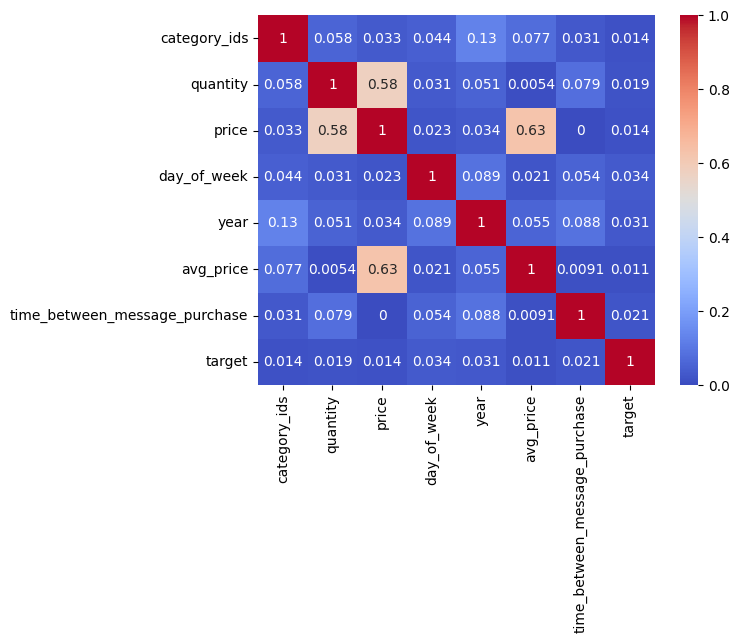

In [61]:
fig, ax = plt.subplots()
sns.heatmap(df.drop(['client_id'], axis=1).phik_matrix(),
            annot=True,
            cmap='coolwarm',
            ax=ax)

**Мультиколлинеарности с целевым признаком не обнаружено**

# Обучение моделей и предсказание

In [62]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['client_id','target'], axis=1),
    df['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=df['target'])

In [63]:
display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(278229, 8)

(278229,)

(92743, 8)

(92743,)

In [64]:
models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'SVC': SVC(probability=True),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=RANDOM_STATE),
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE)
}

# Конструкция Pipeline
pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))  # Начальное значение, будет заменено в GridSearchCV
])

# Определение параметров для поиска
param_dist = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
    },
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf'],
    },
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__iterations': [50],
        'models__depth': [3, 5],
    },
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
    },
]


search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist,
    n_iter=10,  # позже увеличить
    cv=3,
    verbose=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier(random_state=12345))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(penalty='l1',
                                                                       random_state=12345,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5)},
                                        {'models': [DecisionTreeClassifier(random_state=12345)],
                                         'models__max_depth': range(2, 5),
                                         'models__max_feature...
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=12345, ...)],
                                         'models__max_depth': [3, 5],
                                         'models__n_estimators': [50]},
                                        {'models': [LGBMClassifier(random_state=12345)],
                                         'models__max_depth': [3, 5],
                                         'models__n_estimators': [50]}],
                   random_state=12345, scoring='roc_auc', verbose=10)

**Решение выбрать `RandomizedSearchCV` обусловлено тем, что в ходе выполнения реальных задач не будет много времени для выбора лучшей модели**

In [65]:
print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print ('Метрика лучшей модели:', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', KNeighborsClassifier(n_neighbors=4))])
Метрика лучшей модели: 0.9222431973942693


**Лучшая модель `KNeighborsClassifier` с 4 соседями**

In [66]:
y_test_pred_proba = search.predict_proba(X_test)[:, 1]
y_test_pred = search.predict(X_test)
# ROC AUC на тестовой выборке
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"ROC AUC на тесте: {roc_auc:.4f}")

ROC AUC на тесте: 0.9453


In [67]:
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Precision: 0.85
Recall: 0.58
ROC AUC: 0.95


**В итоге на тесте было получено\
`Precision`: 0.85\
`Recall`: 0.58\
`ROC AUC`: 0.95**

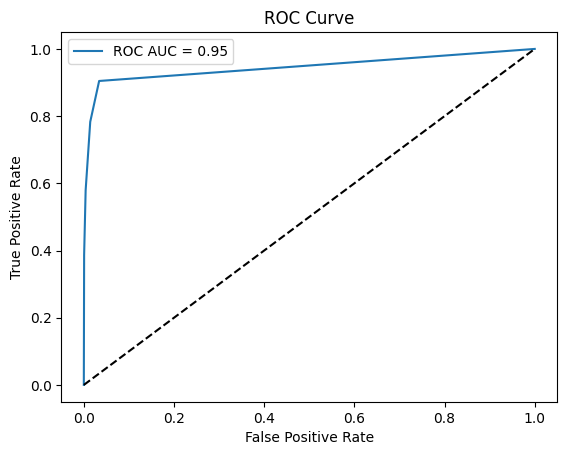

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Для построения ROC кривой можно использовать matplotlib:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайных предсказаний
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

**ROC-AUC кривая близка к идеалу. На самом то деле, есть подозрение что я где то не прав.**

In [84]:
X_train.columns 

Index(['category_ids', 'quantity', 'price', 'day_of_week', 'year', 'avg_price',
       'time_between_message_purchase', 'time_between_message_event'],
      dtype='object')

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


**В работе по прогнозированию совершения покупки в ближайшие 90 дней были предобработаны датасеты, проведен исследовательский анализ данных и обучены несколько моделей. В датасете с покупками удаленеие дубликатов не проводилось так как пользователи могут совершать несколько покупок.\
Также были сгенерированы новые призкнаки. В итоговом обучении моделей приняли участие следующие признаки:**
- `category_ids` - категория;
- `quantity` - количество заказов;
- `price` - общая сумма заказов;
- `day_of_week` - день недели;
- `year` - год заказа;
- `avg_price` - средняя цена одного заказа;
- `time_between_message_purchase` - количество дней с момента отправки сообщения до покупки;
- `time_between_message_event` - количество дней с момента отправки сообщения до совершения действия.

**Лучшей моделью оказалась `KNeighborsClassifier` с 4 соседями `roc-auc` метрика на тестовой выборке равна 0.95**
